# UCI regression eval

In [81]:
import os
import re
import jax
import toml
import datagen
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold",
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
    # "WLF-OGD": "silver",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from matplotlib import colors
cmap_rgb = {
    c: colors.cnames[v]
    for c, v in cmap.items()
}
cmap_rgb

{'EKF-IW': '#DC143C',
 'WLF-IMQ': '#1E90FF',
 'EKF': '#20B2AA',
 'WLF-MD': '#FFD700',
 'OGD': '#8A2BE2',
 'EKF-B': '#FF8C00'}

In [44]:
path_base = "./results"
# experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" not in f)]
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error10" in f)]
sorted(experiment_names)

info_datasets = []
uci = datagen.UCIDatasets("./data")
for dataset_name in sorted(uci.datasets, key=lambda x: -len(x)):
    dataset = uci.load_dataset(dataset_name)
    nrows, ncols = dataset.shape
    
    info_datasets.append({
        "dataset": dataset_name.split("-")[0].capitalize(),
        "nrows": nrows,
        "ncols": ncols
    })

info_datasets = pd.DataFrame(info_datasets).sort_values("dataset")

n_hidden = 20
info_datasets["nparams"] = info_datasets["ncols"] * n_hidden + n_hidden + n_hidden * 1 + 1

info_datasets

,dataset,nrows,ncols,nparams
3,Bostonhousing,506,14,321
5,Concrete,1030,9,221
6,Energy,768,9,221
7,Kin8nm,8192,9,221
1,Naval,11934,18,401
4,Power,9568,5,141
0,Protein,45730,10,241
2,Wine,1599,12,281
8,Yacht,308,7,181


In [45]:
print(
    info_datasets
    .set_index("dataset").style.to_latex(hrules=True).replace("_", "-")
)

\begin{tabular}{lrrr}
\toprule
 & nrows & ncols & nparams \\
dataset &  &  &  \\
\midrule
Bostonhousing & 506 & 14 & 321 \\
Concrete & 1030 & 9 & 221 \\
Energy & 768 & 9 & 221 \\
Kin8nm & 8192 & 9 & 221 \\
Naval & 11934 & 18 & 401 \\
Power & 9568 & 5 & 141 \\
Protein & 45730 & 10 & 241 \\
Wine & 1599 & 12 & 281 \\
Yacht & 308 & 7 & 181 \\
\bottomrule
\end{tabular}



In [46]:
df_results_all = []
for file_name in experiment_names:
    dataset = file_name.replace("-target.pkl", "")
    path = os.path.join(path_base, file_name)
    with open(path, "rb") as f:
        experiment = pickle.load(f)

    errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["pp_estimates"])
    
    running_times = experiment["time"].copy()
    # del running_times["EKF-B"]    # REMOVE AFTER REFACTORING
    running_times = pd.DataFrame(running_times)

    df_results = pd.DataFrame({
        name: np.median(errors[name], axis=1)
        for name in errors
    })

    df_results = df_results.reset_index().melt("index", value_name="err")
    running_times = running_times.reset_index().melt("index", value_name="time")
    
    df_results = pd.merge(
        df_results,
        running_times,
        on=["index", "variable"],
    )
    
    df_results["dataset"] = dataset
    df_results_all.append(df_results)

df_results_all = pd.concat(df_results_all, axis=0)

# Root median squared error
df_results_all["err"] = np.sqrt(df_results_all["err"])
df_results_all["dataset"] = df_results_all["dataset"].str.replace("-.*", "", regex=True).str.capitalize()
df_results_all = df_results_all.rename({"index": "run", "variable": "method"}, axis=1)
df_results_all = df_results_all.merge(info_datasets, on="dataset")
df_results_all["method"] = df_results_all["method"].apply(lambda x: x.replace("KF", "EKF"))

df_results_all = df_results_all.query("run > 0")
df_results_all = df_results_all.query("method != 'WLF-OGD'")

/tmp/ipykernel_305004/4197190141.py:8: RuntimeWarning: overflow encountered in power
  errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["pp_estimates"])
/tmp/ipykernel_305004/4197190141.py:8: RuntimeWarning: overflow encountered in power
  errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["pp_estimates"])
/tmp/ipykernel_305004/4197190141.py:8: RuntimeWarning: overflow encountered in power
  errors = jax.tree_map(lambda x: np.power(x - experiment["datasets"]["y"], 2), experiment["pp_estimates"])


In [47]:
df_results_all.sample(10, random_state=314)

,run,method,err,time,dataset,nrows,ncols,nparams
1814,14,EKF,1.770894,0.009209,Bostonhousing,506,14,321
4888,88,EKF,0.645998,0.221507,Naval,11934,18,401
2019,19,EKF-IW,0.069863,0.097060,Bostonhousing,506,14,321
3836,36,EKF-IW,0.122573,0.049080,Wine,1599,12,281
1630,30,WLF-IMQ,0.091689,0.110571,Kin8nm,8192,9,221
1795,95,WLF-MD,0.091086,0.116006,Kin8nm,8192,9,221
2737,37,OGD,0.352336,0.074898,Power,9568,5,141
2446,46,EKF,0.645506,0.111056,Power,9568,5,141
1964,64,EKF-B,0.071639,0.104642,Bostonhousing,506,14,321
3896,96,EKF-IW,0.091997,0.049237,Wine,1599,12,281


In [48]:
df_results_all["timestep"] = df_results_all["time"] / (df_results_all["nrows"]) * 1e6

In [49]:
datasets = sorted(df_results_all.dataset.unique())
print(datasets)

['Bostonhousing', 'Concrete', 'Energy', 'Kin8nm', 'Naval', 'Power', 'Protein', 'Wine', 'Yacht']


In [51]:
df_results_all.pivot_table(columns="method", index="dataset", values="err", aggfunc="mean")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,1.639570,0.072764,6.604020e-02,0.861995,0.071976,0.069862
Concrete,1.726488,0.091468,8.875082e-02,0.666210,0.089479,0.089371
Energy,1.604005,0.046909,4.325133e-02,0.746401,0.048839,0.042908
Kin8nm,0.741313,0.089853,9.118173e-02,0.410146,0.096985,0.088467
Naval,0.579175,0.107323,1.702620e-01,0.379949,0.106974,0.102753
Power,0.567490,0.048708,1.083276e+07,0.389459,0.048683,0.048516
Protein,0.497726,0.190794,2.091823e-01,0.328782,0.196482,0.191255
Wine,0.975592,0.107959,6.063145e-01,0.545907,0.107972,0.105973
Yacht,1.449850,0.127684,4.300774e-02,0.997910,0.119153,0.119849


In [52]:
markers = {
    "EKF": "v",
    "EKF-B": "^",
    "EKF-IW": "D",
    "WLF-IMQ": "o",
    "WLF-MD": "*",
    "OGD": "s"
}


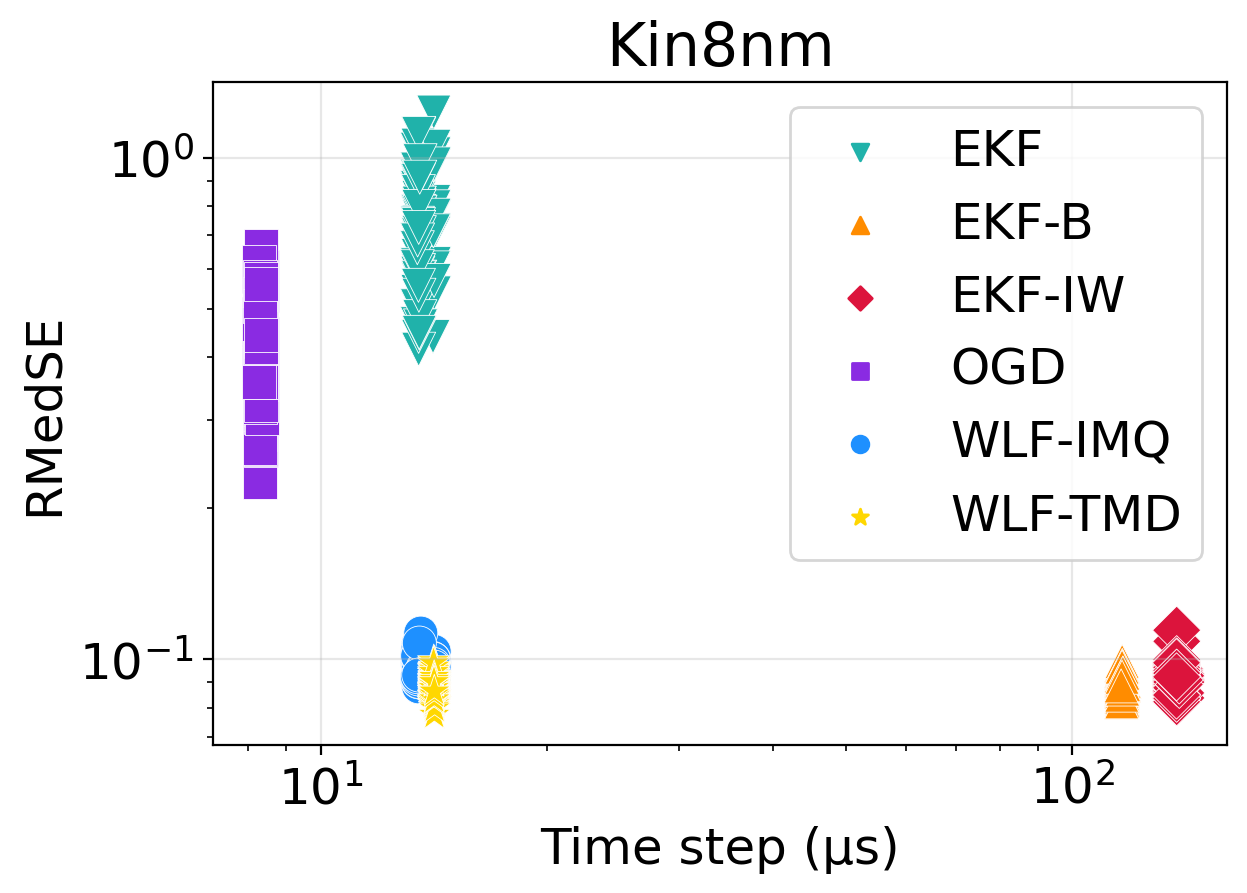

In [53]:
algorithms = sorted(cmap.keys())

dataset = "Kin8nm"
p = sns.scatterplot(
    y="err", x="timestep", hue="method", style="method",
    markers=markers,
    data=df_results_all.query("dataset == @dataset").query("run > 0"),
    palette=cmap, s=150,
    hue_order=algorithms,
    linewidth=0.3,
)
plt.legend(ncol=1, loc="upper right")

for text in p.legend(ncol=1, loc="upper right").texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))


plt.title(dataset)
plt.xlabel("Time step (μs)")
plt.ylabel("RMedSE")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.xscale("log")
plt.yscale("log")
# plt.savefig(f"./figures/{dataset.lower()}-time-v-err.png", dpi=300)

In [54]:
summary_timestep = df_results_all.pivot_table(index="dataset", columns="method", values="timestep")

method = "WLF-IMQ"
summary_timestep.div(summary_timestep["WLF-IMQ"], axis="rows")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0.995773,11.268477,10.391104,0.754634,1.0,1.057640
Concrete,0.965813,12.672341,1.611331,0.592465,1.0,1.000853
Energy,0.995024,6.865493,6.034741,0.625741,1.0,1.060927
Kin8nm,0.999485,8.545734,10.118299,0.610313,1.0,1.039271
Naval,0.988121,9.385227,3.928221,0.439981,1.0,1.002884
Power,0.982687,14.075390,6.062468,0.669479,1.0,1.000997
Protein,1.000045,7.164719,1.680032,0.584947,1.0,1.001817
Wine,1.001177,12.116664,1.808742,0.520199,1.0,1.002072
Yacht,0.992194,7.227668,8.358612,1.465799,1.0,1.008478


In [55]:
summary_err = df_results_all.pivot_table(index="dataset", columns="method", values="err")

method = "WLF-IMQ"
summary_err.div(summary_err[method], axis="rows")

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,22.779457,1.010955,9.175333e-01,11.976176,1.0,0.970627
Concrete,19.294909,1.022232,9.918627e-01,7.445440,1.0,0.998797
Energy,32.842484,0.960467,8.855842e-01,15.282795,1.0,0.878547
Kin8nm,7.643620,0.926472,9.401680e-01,4.228983,1.0,0.912178
Naval,5.414159,1.003259,1.591620e+00,3.551787,1.0,0.960542
Power,11.656924,1.000527,2.225179e+08,7.999953,1.0,0.996568
Protein,2.533193,0.971051,1.064641e+00,1.673347,1.0,0.973401
Wine,9.035599,0.999876,5.615478e+00,5.056008,1.0,0.981483
Yacht,12.167977,1.071599,3.609457e-01,8.375035,1.0,1.005840


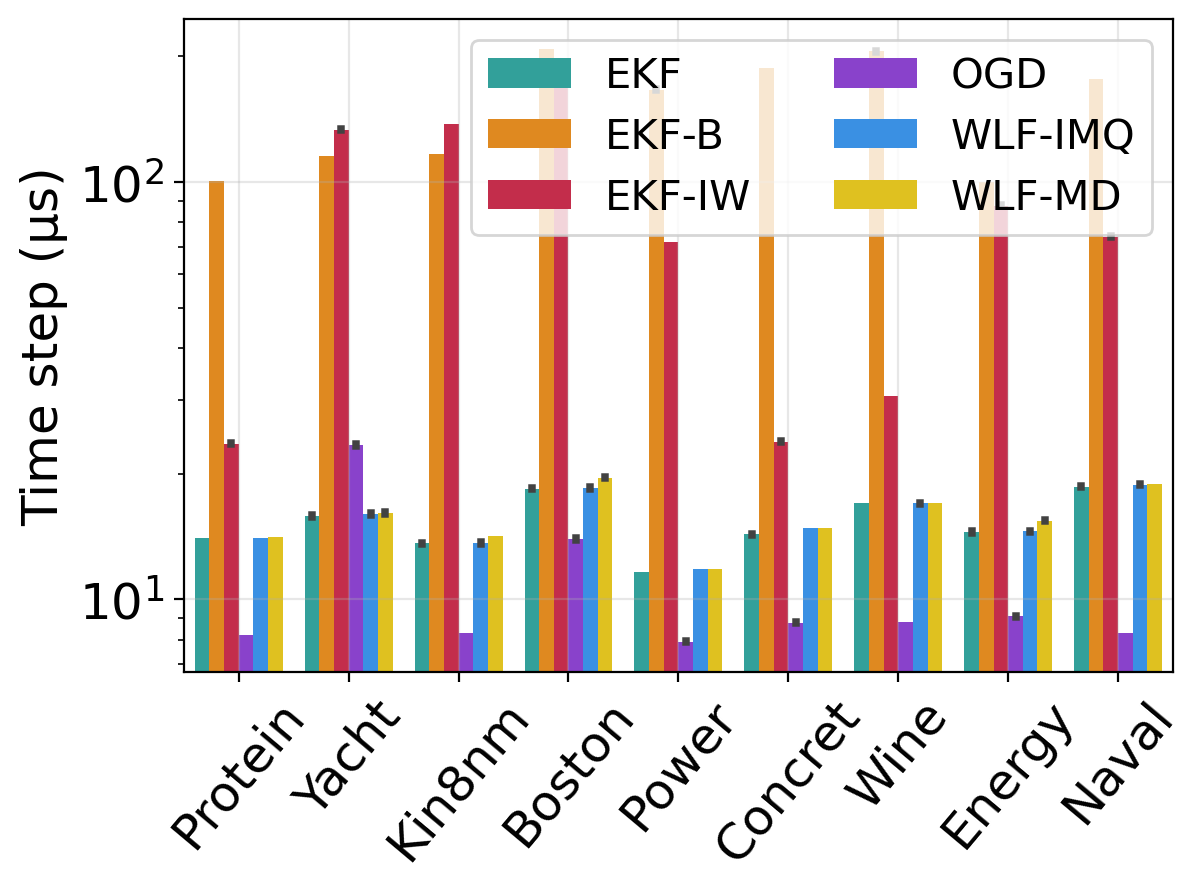

In [56]:
sns.barplot(
    x="dataset",
    y="timestep",
    hue="method",
    palette=cmap,
    data=(
        df_results_all.assign(dataset=df_results_all.dataset.str[:7].str.replace("nh", "n"))
    ),
)
plt.legend(ncol=2, fontsize=15, loc="upper right")
plt.xticks(rotation=50)
plt.grid(alpha=0.3)
plt.xlabel("")
plt.ylabel("Time step (μs)")
plt.tight_layout()
plt.yscale("log")
# plt.savefig(f"./figures/uci-time-comparison.png", dpi=300)

In [57]:
relative_to = "OGD"
metric = "timestep"

for metric in ["err", "timestep"]:
    rel_metric = f"rel_{metric}"
    timestep_ogd = df_results_all.query("method == @relative_to").groupby("dataset")[metric].mean()
    df_results_all[rel_metric] = df_results_all.apply(lambda x: x[metric] / timestep_ogd[x["dataset"]] - 1, axis=1)

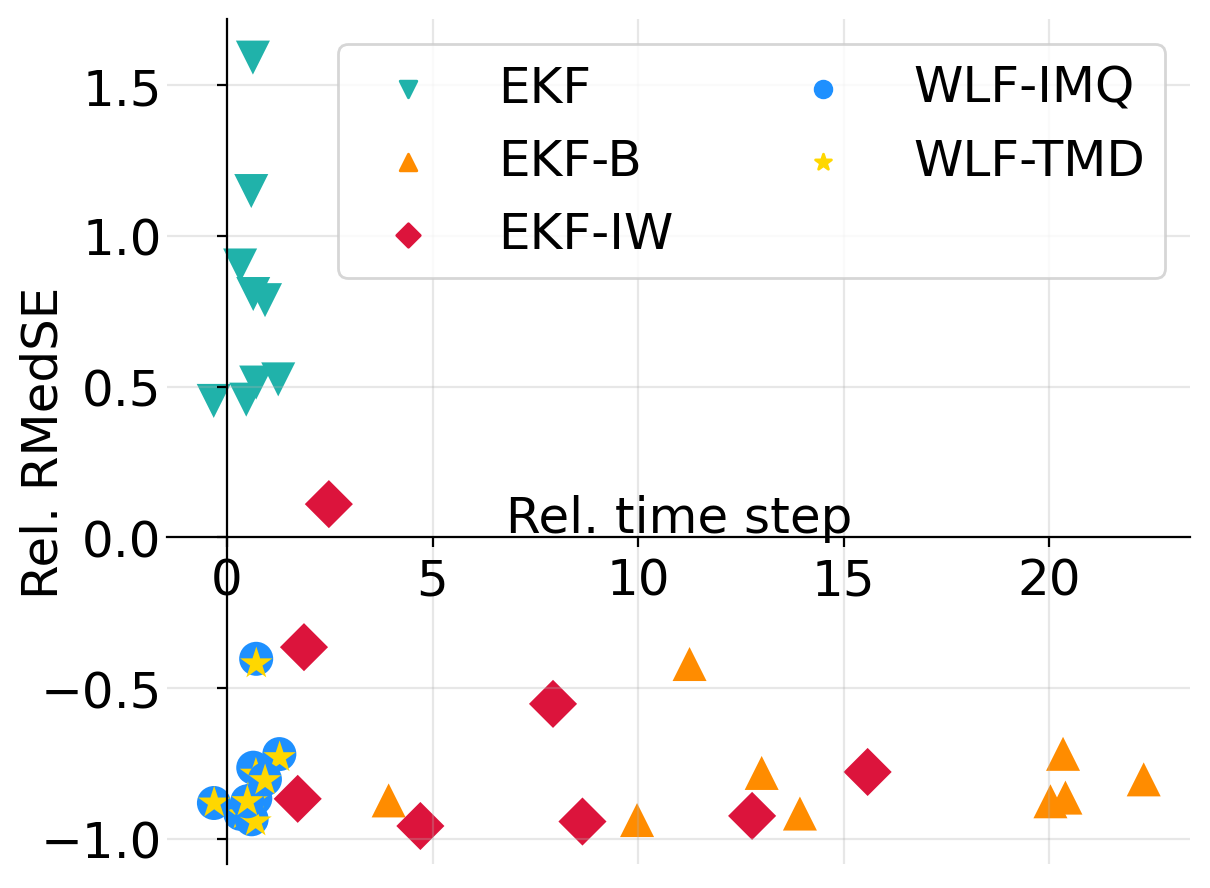

In [68]:
fig, ax = plt.subplots()
outp_df = df_results_all.groupby(["dataset", "method"])[["rel_timestep", "rel_err", "ncols"]].mean().reset_index()
# outp_df = outp_df.melt(["dataset", "method"], var_name="metric")
p = sns.scatterplot(
    x="rel_timestep",
    y="rel_err",
    hue="method",
    data=outp_df.query("method != 'OGD'").query("rel_err < 10"),
    palette=cmap,
    s=150,
    markers=markers,
    style="method",
    linewidth=0,
    edgecolor="black"
)
plt.grid(alpha=0.3)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)
plt.xticks()
ax.tick_params(direction='out', pad=20, axis="y")

for text in p.legend(ncol=2).texts:
    text.set_text(text.get_text().replace("-MD", "-TMD"))


plt.xlabel("Rel. time step", loc="center", labelpad=-40)
plt.ylabel("Rel. RMedSE", labelpad=-10)
plt.tight_layout()
# plt.savefig("./figures/relative-ogd-metrics-datasets.png", dpi=300)

In [69]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_timestep").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,0.319544,0.630162,0.590154,0.637659,1.245824,0.467837,0.709633,0.924603,-0.323104
EKF-B,13.932368,20.389197,9.971789,13.002208,20.330964,20.024384,11.248487,22.292364,3.930873
EKF-IW,12.769722,1.719708,8.644159,15.578861,7.928152,8.055497,1.872108,2.477020,4.702428
OGD,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
WLF-IMQ,0.325145,0.687865,0.598107,0.638503,1.272823,0.493698,0.709556,0.922341,-0.317778
WLF-MD,0.401526,0.689305,0.695474,0.702848,1.279377,0.495188,0.712663,0.926325,-0.311994


In [70]:
df_results_all.pivot_table(index="method", columns="dataset", values="rel_err").style

dataset,Bostonhousing,Concrete,Energy,Kin8nm,Naval,Power,Protein,Wine,Yacht
method,,,,,,,,,
EKF,0.902064,1.591507,1.148984,0.807437,0.524348,0.457124,0.513848,0.787101,0.452887
EKF-B,-0.915586,-0.862704,-0.937154,-0.780923,-0.717534,-0.874933,-0.419695,-0.802240,-0.872048
EKF-IW,-0.923387,-0.866783,-0.942054,-0.777685,-0.551882,27814895.996460,-0.363765,0.110654,-0.956902
OGD,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000
WLF-IMQ,-0.916501,-0.865690,-0.934567,-0.763537,-0.718452,-0.874999,-0.402395,-0.802216,-0.880598
WLF-MD,-0.918954,-0.865851,-0.942514,-0.784303,-0.729561,-0.875428,-0.418291,-0.805878,-0.879900


### Table of results

In [71]:
def format_entry(entry):
    # entry = entry[entry < 1000]
    mean = entry.mean()
    std = entry.std()
    if std > 1000:
        label = rf"$-$"
    else:
        label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [72]:
res = (
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=format_entry)
)
res

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,$1.64 \pm 0.57$,$0.07 \pm 0.01$,$0.07 \pm 0.01$,$0.86 \pm 0.44$,$0.07 \pm 0.01$,$0.07 \pm 0.01$
Concrete,$1.73 \pm 0.51$,$0.09 \pm 0.01$,$0.09 \pm 0.01$,$0.67 \pm 0.20$,$0.09 \pm 0.01$,$0.09 \pm 0.01$
Energy,$1.60 \pm 0.46$,$0.05 \pm 0.00$,$0.04 \pm 0.00$,$0.75 \pm 0.28$,$0.05 \pm 0.00$,$0.04 \pm 0.00$
Kin8nm,$0.74 \pm 0.17$,$0.09 \pm 0.00$,$0.09 \pm 0.00$,$0.41 \pm 0.09$,$0.10 \pm 0.00$,$0.09 \pm 0.00$
Naval,$0.58 \pm 0.09$,$0.11 \pm 0.00$,$0.17 \pm 0.02$,$0.38 \pm 0.06$,$0.11 \pm 0.01$,$0.10 \pm 0.01$
Power,$0.57 \pm 0.13$,$0.05 \pm 0.00$,$-$,$0.39 \pm 0.08$,$0.05 \pm 0.00$,$0.05 \pm 0.00$
Protein,$0.50 \pm 0.07$,$0.19 \pm 0.00$,$0.21 \pm 0.00$,$0.33 \pm 0.03$,$0.20 \pm 0.00$,$0.19 \pm 0.00$
Wine,$0.98 \pm 0.33$,$0.11 \pm 0.01$,$0.61 \pm 4.97$,$0.55 \pm 0.18$,$0.11 \pm 0.01$,$0.11 \pm 0.01$
Yacht,$1.45 \pm 0.58$,$0.13 \pm 0.02$,$0.04 \pm 0.01$,$1.00 \pm 0.48$,$0.12 \pm 0.02$,$0.12 \pm 0.02$


In [73]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllllll}
\toprule
method & EKF & EKF-B & EKF-IW & OGD & WLF-IMQ & WLF-MD \\
dataset &  &  &  &  &  &  \\
\midrule
Bostonhousing & $1.64 \pm 0.57$ & $0.07 \pm 0.01$ & $0.07 \pm 0.01$ & $0.86 \pm 0.44$ & $0.07 \pm 0.01$ & $0.07 \pm 0.01$ \\
Concrete & $1.73 \pm 0.51$ & $0.09 \pm 0.01$ & $0.09 \pm 0.01$ & $0.67 \pm 0.20$ & $0.09 \pm 0.01$ & $0.09 \pm 0.01$ \\
Energy & $1.60 \pm 0.46$ & $0.05 \pm 0.00$ & $0.04 \pm 0.00$ & $0.75 \pm 0.28$ & $0.05 \pm 0.00$ & $0.04 \pm 0.00$ \\
Kin8nm & $0.74 \pm 0.17$ & $0.09 \pm 0.00$ & $0.09 \pm 0.00$ & $0.41 \pm 0.09$ & $0.10 \pm 0.00$ & $0.09 \pm 0.00$ \\
Naval & $0.58 \pm 0.09$ & $0.11 \pm 0.00$ & $0.17 \pm 0.02$ & $0.38 \pm 0.06$ & $0.11 \pm 0.01$ & $0.10 \pm 0.01$ \\
Power & $0.57 \pm 0.13$ & $0.05 \pm 0.00$ & $-$ & $0.39 \pm 0.08$ & $0.05 \pm 0.00$ & $0.05 \pm 0.00$ \\
Protein & $0.50 \pm 0.07$ & $0.19 \pm 0.00$ & $0.21 \pm 0.00$ & $0.33 \pm 0.03$ & $0.20 \pm 0.00$ & $0.19 \pm 0.00$ \\
Wine & $0.98 \pm 0.33$ & $0.11 \pm 0.01$ & $0.61

In [74]:
(
    df_results_all
    .pivot_table(columns="method", index="dataset", values="err", aggfunc=lambda x: (x > 1000).sum())
)

method,EKF,EKF-B,EKF-IW,OGD,WLF-IMQ,WLF-MD
dataset,,,,,,
Bostonhousing,0,0,0,0,0,0
Concrete,0,0,0,0,0,0
Energy,0,0,0,0,0,0
Kin8nm,0,0,0,0,0,0
Naval,0,0,0,0,0,0
Power,0,0,7,0,0,0
Protein,0,0,0,0,0,0
Wine,0,0,0,0,0,0
Yacht,0,0,0,0,0,0


## Store config 

In [83]:
dataset_name = "kin8nm"
file_name = f"{dataset_name}-target-p-error10.pkl"
path = os.path.join(path_base, file_name)
with open(path, "rb") as f:
    experiment = pickle.load(f)
    hparams = experiment["configs"].copy()

In [84]:
config = {}
p_error = experiment["p-error"]
dataset_name = experiment["dataset-name"]
config["metadata"] = {
    "p-error": p_error,
    "dataset-name": dataset_name,
}

config["hyperparams"] = hparams

In [85]:
filename_out = f"hparams-{dataset_name}-p-error{p_error * 100:0.0f}.toml"
filename_out

'hparams-kin8nm-p-error10.toml'

In [86]:
path = os.path.join("configs", filename_out)
with open(path, "w") as f:
    toml.dump(config, f, encoder=toml.TomlNumpyEncoder())